[Eitz et al](http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/) asked non-expert humans to sketch objects of a given category and gather 20,000 unique sketches evenly distributed over 250 object categories.

    @article{eitz2012hdhso,
        author={Eitz, Mathias and Hays, James and Alexa, Marc},
        title={How Do Humans Sketch Objects?},
        journal={ACM Trans. Graph. (Proc. SIGGRAPH)},
        year={2012},
        volume={31},
        number={4},
        pages = {44:1--44:10}
    }

#Download

Download png images (525MB):

In [ ]:
%%bash
cd ~/Downloads
wget http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip
unzip sketches_png.zip

In [1]:
files = !find ~/Downloads/png -name "*.png"
len(files)

20000

##show sample sketch

In [2]:
#Import libraries for doing image analysis
from skimage.io import imread
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier as RF
import glob
import os
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from matplotlib import colors
from pylab import cm
from skimage import segmentation
from skimage.morphology import watershed
from skimage import measure
from skimage import morphology
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage.feature import peak_local_max
# make graphics inline
%matplotlib inline

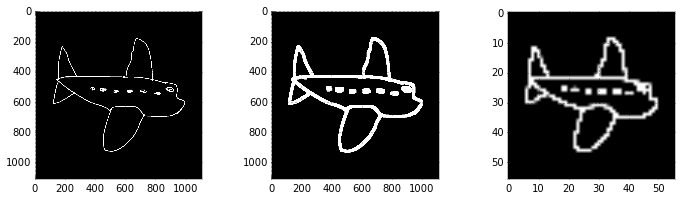

In [3]:
plt.figure(figsize=(12,3))
image = imread(files[0], as_grey=True)
imagethr = np.where(image > np.mean(image),0.,1.0)

plt.subplot(1,3,1)
plt.imshow(imagethr, cmap=cm.gray);
imdilated = morphology.dilation(imagethr, np.ones((16,16)))
plt.subplot(1,3,2)
plt.imshow(imdilated, cmap=cm.gray);

im1 = resize(imdilated,[56,56])
plt.subplot(1,3,3)
plt.imshow(im1, cmap=cm.gray);
# plt.show()

#Read

In [4]:
def process(fname):
    image = imread(fname, as_grey=True)
    imagethr = np.where(image > np.mean(image),0.,1.)
    imdilated = morphology.dilation(imagethr, np.ones((16,16)))
    im1 = resize(imdilated,[56,56])
    return im1.ravel().astype(np.int8)

forever divided by eight is also forever :(

In [5]:
import multiprocessing as mp
NUM_PROCESSES = 8
pool = mp.Pool(NUM_PROCESSES)
results = pool.map(process, files, chunksize=100)
pool.close()
pool.join()

In [31]:
y = np.array(map(lambda f: f.split('/')[-2], files))

In [32]:
X = np.array(results)
N, image_size = X.shape
D = int(np.sqrt(image_size))
N, image_size, D

(20000, 3136, 56)

shuffle the order of the images

In [33]:
import random
s = random.sample(xrange(N),N)
X=X[s]
y=y[s]

In [44]:
y.dtype

dtype('S18')

In [49]:
N_train = int(0.9 * N)
N_test = N - N_train
N_train, N_test

(18000, 2000)

#HDF5

Save all images in a format that can be used by [fuel](http://fuel.readthedocs.org/en/latest/h5py_dataset.html)

In [36]:
import fuel
datasource = 'sketch'
datasource_dir = os.path.join(fuel.config.data_path, datasource)
!mkdir -p {datasource_dir}
datasource_fname = os.path.join(datasource_dir , datasource+'.hdf5')
datasource_fname

'/Users/udi/Downloads/lisa/sketch/sketch.hdf5'

In [42]:
import h5py
fp = h5py.File(datasource_fname, mode='w')
image_features = fp.create_dataset('features', (N, image_size), dtype='uint8')

In [43]:
image_features[...] = X

In [46]:
targets = fp.create_dataset('targets', (N, 1), dtype='S18')

In [48]:
targets[...] = y.reshape(-1,1)

In [50]:
from fuel.datasets.hdf5 import H5PYDataset
split_dict = {
    'train': {'features': (0, N_train), 'targets': (0, N_train)},
    'test': {'features': (N_train, N), 'targets': (N_train, N)}
}
fp.attrs['split'] = H5PYDataset.create_split_array(split_dict)

In [51]:
fp.flush()
fp.close()

In [52]:
!ls -l {datasource_fname}

-rw-r--r--  1 udi  staff  63082720 Apr 20 15:49 /Users/udi/Downloads/lisa/sketch/sketch.hdf5


In [53]:
!aws s3 cp {datasource_fname} s3://udidraw/ --grants read=uri=http://acs.amazonaws.com/groups/global/AllUsers

upload: ../../../../../../../Downloads/lisa/sketch/sketch.hdf5 to s3://udidraw/sketch.hdf5


#Test

In [55]:
train_set = H5PYDataset(datasource_fname, which_set='train')

In [57]:
train_set.num_examples

18000

In [58]:
train_set.provides_sources

(u'features', u'targets')

In [69]:
handle = train_set.open()
data = train_set.get_data(handle, slice(0, 16))
data[0].shape,data[1].shape

((16, 3136), (16, 1))

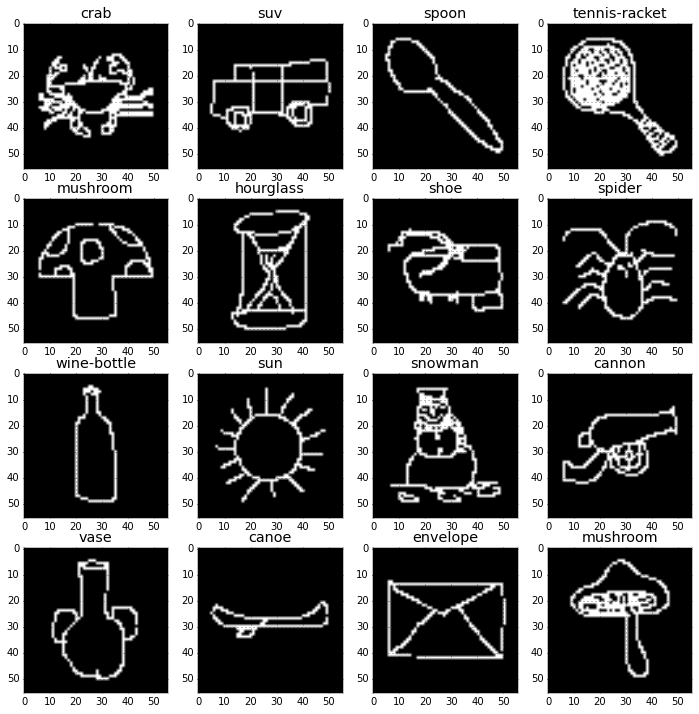

In [71]:
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[0][i].reshape(D,D), cmap=cm.gray)
    plt.title(data[1][i][0]);

In [72]:
train_set.close(handle)